# Projet 8 : Déployer un modèle dans le cloud

## I - Présentation du projet

Ce projet s'inscrit dans le cadre du développement d'une application mobile qui permettrait aux utilisateurs de prendre en photo un fruit et d'obtenir des informations sur ce fruit.

L'objectif de ce projet est de développer un environnement Big Data qui comprendra le preprocessing et une étape de réduction de dimension.

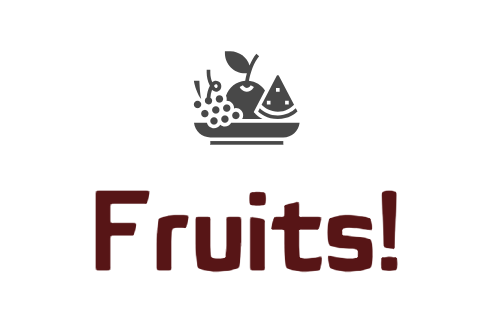

## Banque d'images

Le jeu de données est un ensemble d'images de fruits et de labels associés :
https://www.kaggle.com/moltean/fruits

### Chargement des librairies

In [ ]:
import time
import pandas as pd
from PIL import Image
import numpy as np
import io

import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array

from pyspark.sql.functions import col, pandas_udf, PandasUDFType

In [0]:
# data handling
from pyspark.sql.functions import element_at, split
from pyspark.sql.functions import pandas_udf, PandasUDFType
# from pyspark.sql.functions import col
from pyspark.sql.functions import udf
from pyspark.sql.types import *
from typing import Iterator

In [0]:
# core featurizer
tf.__version__

Out[3]: '2.10.0'

In [0]:
path_work = "s3://elfenaouy/Images/*"

In [0]:
# function to load data into into a spark_df
# with spaces of folder's name removed first, inferschema optional here
start = time.perf_counter()
df_img = spark.read.format('binaryFile').load(path_work, inferschema=True) 
stop = time.perf_counter()
print(f'data load with spark.read, elapsed time: {stop - start:0.2f}s')

data load with spark.read, elapsed time: 3.02s

In [0]:
# number of images in this sample
df_img.count()

Out[6]: 75

In [0]:
start = time.perf_counter()
df_img.show(20)
stop = time.perf_counter()
print(f'data load with spark.read, elapsed time: {stop - start:0.2f}s')

+--------------------+-------------------+------+--------------------+
 path| modificationTime|length| content|
+--------------------+-------------------+------+--------------------+
s3://elfenaouy/Im...|2022-10-14 23:27:02| 6119|[FF D8 FF E0 00 1...|
s3://elfenaouy/Im...|2022-10-14 23:43:09| 5811|[FF D8 FF E0 00 1...|
s3://elfenaouy/Im...|2022-10-14 23:27:11| 5805|[FF D8 FF E0 00 1...|
s3://elfenaouy/Im...|2022-10-14 23:27:16| 5758|[FF D8 FF E0 00 1...|
s3://elfenaouy/Im...|2022-10-14 23:43:03| 5616|[FF D8 FF E0 00 1...|
s3://elfenaouy/Im...|2022-10-14 23:30:22| 5515|[FF D8 FF E0 00 1...|
s3://elfenaouy/Im...|2022-10-14 23:30:18| 5499|[FF D8 FF E0 00 1...|
s3://elfenaouy/Im...|2022-10-14 23:30:13| 5462|[FF D8 FF E0 00 1...|
s3://elfenaouy/Im...|2022-10-14 23:43:14| 5314|[FF D8 FF E0 00 1...|
s3://elfenaouy/Im...|2022-10-14 23:57:47| 5292|[FF D8 FF E0 00 1...|
s3://elfenaouy/Im...|2022-10-14 23:45:09| 5272|[FF D8 FF E0 00 1...|
s3://elfenaouy/Im...|2022-10-14 23:44:44| 5246|[FF D8 FF E0 00 1...|
s3://elfenaouy/Im...|2022-10-14 23:57:46| 5240|[FF D8 FF E0 00 1...|
s3://elfenaouy/Im...|2022-10-14 23:45:02| 5215|[FF D8 FF E0 00 1...|
s3://elfenaouy/Im...|2022-10-14 23:53:30| 5153|[FF D8 FF E0 00 1...|
s3://elfenaouy/Im...|2022-10-14 23:53:23| 5149|[FF D8 FF E0 00 1...|
s3://elfenaouy/Im...|2022-10-14 23:57:47| 5075|[FF D8 FF E0 00 1...|
s3://elfenaouy/Im...|2022-10-14 23:53:27| 5074|[FF D8 FF E0 00 1...|
s3://elfenaouy/Im...|2022-10-15 00:03:14| 5047|[FF D8 FF E0 00 1...|
s3://elfenaouy/Im...|2022-10-14 23:23:09| 4941|[FF D8 FF E0 00 1...|
+--------------------+-------------------+------+--------------------+
only showing top 20 rows

data load with spark.read, elapsed time: 4.60s

In [0]:
# display DataFrame schema 
df_img.printSchema()

root
-- path: string (nullable = true)
-- modificationTime: timestamp (nullable = true)
-- length: long (nullable = true)
-- content: binary (nullable = true)

In [0]:
# origin detail
df_img.select('path').show(1, False, True)

-RECORD 0--------------------------------------------
 path | s3://elfenaouy/Images/Cauliflower/70_100.jpg 
only showing top 1 row

In [0]:
# extract label from image.origin
df_img = df_img.withColumn('label', element_at(split(df_img['path'], "/"), -2))

In [0]:
# show first 3 rows with image struct detailed
df_img.select('path','content','label').show(1, True)

+--------------------+--------------------+-----------+
 path| content| label|
+--------------------+--------------------+-----------+
s3://elfenaouy/Im...|[FF D8 FF E0 00 1...|Cauliflower|
+--------------------+--------------------+-----------+
only showing top 1 row

# Use of a CNN as feature extractor

In [0]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array

from pyspark.sql.functions import col, pandas_udf, PandasUDFType

In [0]:
model = ResNet50(include_top=False)

Downloading data from https://storage.googleapis.com/tensorflow/keras-applications/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
 8192/94765736 [..............................] - ETA: 0s 245760/94765736 [..............................] - ETA: 19s 3407872/94765736 [>.............................] - ETA: 2s  5275648/94765736 [>.............................] - ETA: 2s11558912/94765736 [==>...........................] - ETA: 1s16957440/94765736 [====>.........................] - ETA: 1s23994368/94765736 [======>.......................] - ETA: 0s30744576/94765736 [========>.....................] - ETA: 0s38166528/94765736 [===========>..................] - ETA: 0s45096960/94765736 [=============>................] - ETA: 0s52224000/94765736 [===============>..............] - ETA: 0s58728448/94765736 [=================>............] - ETA: 0s65593344/94765736 [===================>..........] - ETA: 0s72613888/94765736 [=====================>........] - ETA: 0s79519744/94765736 [========================>.....] - ETA: 0s86532096/94765736 [==========================>...] - ETA: 0s93544448/94765736 [============================>.] - ETA: 0s94765736/94765736 [==============================] - 1s 0us/step

In [0]:
bc_model_weights = sc.broadcast(model.get_weights())

In [0]:
def model_fn():
    
    model = ResNet50(weights=None, include_top=False)
    model.set_weights(bc_model_weights.value)
    return model

In [0]:
def preprocess(content):
    
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)
    



In [0]:
def featurize_series(model, content_series):
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    output = [p.flatten() for p in preds]
    return pd.Series(output)
    

In [0]:
@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)
    

In [0]:
features_df = df_img.select(col("path"),col("label"), featurize_udf("content").alias("features"))

In [0]:
features_df.show(20)

+--------------------+-----------+--------------------+
 path| label| features|
+--------------------+-----------+--------------------+
s3://elfenaouy/Im...|Cauliflower|[0.0, 0.0, 0.0, 0...|
s3://elfenaouy/Im...| Onion Red|[0.0, 0.0, 0.0, 0...|
s3://elfenaouy/Im...|Cauliflower|[0.0, 0.0, 0.0, 0...|
s3://elfenaouy/Im...|Cauliflower|[0.0, 0.0, 0.0, 0...|
s3://elfenaouy/Im...| Onion Red|[0.0, 0.0, 0.0, 0...|
s3://elfenaouy/Im...| Cocos|[0.0, 0.0, 0.0, 0...|
s3://elfenaouy/Im...| Cocos|[0.0, 0.0, 0.0, 0...|
s3://elfenaouy/Im...| Cocos|[0.0, 0.0, 0.0, 0...|
s3://elfenaouy/Im...| Onion Red|[0.0, 0.0, 0.0, 0...|
s3://elfenaouy/Im...| Plum|[0.0, 0.0, 0.0, 0...|
s3://elfenaouy/Im...| Orange|[0.0, 0.0, 0.0, 0...|
s3://elfenaouy/Im...| Orange|[0.0, 0.0, 0.0, 0...|
s3://elfenaouy/Im...| Plum|[0.0, 0.0, 0.0, 0...|
s3://elfenaouy/Im...| Orange|[0.0, 0.0, 0.0, 0...|
s3://elfenaouy/Im...| Peach|[0.0, 0.0, 0.0, 0...|
s3://elfenaouy/Im...| Peach|[0.0, 0.0, 0.0, 0...|
s3://elfenaouy/Im...| Plum|[0.0, 0.0, 0.0, 0...|
s3://elfenaouy/Im...| Peach|[0.0, 0.0, 0.0, 0...|
s3://elfenaouy/Im...| Tamarillo|[2.8520603, 0.0, ...|
s3://elfenaouy/Im...| Carambula|[0.0, 0.0, 0.0, 0...|
+--------------------+-----------+--------------------+
only showing top 20 rows

# Réduction de dimension , PCA (API saprkMLib):


In [0]:
from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors, VectorUDT
#convert array to vecteur dense
to_vector = udf(lambda x: Vectors.dense(x), VectorUDT())
sparkDF = features_df.select('path', 'label','features', to_vector("features").alias("features_vec"))

In [0]:
sparkDF.show()

+--------------------+-----------+--------------------+--------------------+
 path| label| features| features_vec|
+--------------------+-----------+--------------------+--------------------+
s3://elfenaouy/Im...|Cauliflower|[0.0, 0.0, 0.0, 0...|[0.0,0.0,0.0,0.0,...|
s3://elfenaouy/Im...| Onion Red|[0.0, 0.0, 0.0, 0...|[0.0,0.0,0.0,0.0,...|
s3://elfenaouy/Im...|Cauliflower|[0.0, 0.0, 0.0, 0...|[0.0,0.0,0.0,0.0,...|
s3://elfenaouy/Im...|Cauliflower|[0.0, 0.0, 0.0, 0...|[0.0,0.0,0.0,0.0,...|
s3://elfenaouy/Im...| Onion Red|[0.0, 0.0, 0.0, 0...|[0.0,0.0,0.0,0.0,...|
s3://elfenaouy/Im...| Cocos|[0.0, 0.0, 0.0, 0...|[0.0,0.0,0.0,0.0,...|
s3://elfenaouy/Im...| Cocos|[0.0, 0.0, 0.0, 0...|[0.0,0.0,0.0,0.0,...|
s3://elfenaouy/Im...| Cocos|[0.0, 0.0, 0.0, 0...|[0.0,0.0,0.0,0.0,...|
s3://elfenaouy/Im...| Onion Red|[0.0, 0.0, 0.0, 0...|[0.0,0.0,0.0,0.0,...|
s3://elfenaouy/Im...| Plum|[0.0, 0.0, 0.0, 0...|[0.0,0.0,0.0,0.0,...|
s3://elfenaouy/Im...| Orange|[0.0, 0.0, 0.0, 0...|[0.0,0.0,0.0,0.0,...|
s3://elfenaouy/Im...| Orange|[0.0, 0.0, 0.0, 0...|[0.0,0.0,0.0,0.0,...|
s3://elfenaouy/Im...| Plum|[0.0, 0.0, 0.0, 0...|[0.0,0.0,0.0,0.0,...|
s3://elfenaouy/Im...| Orange|[0.0, 0.0, 0.0, 0...|[0.0,0.0,0.0,0.0,...|
s3://elfenaouy/Im...| Peach|[0.0, 0.0, 0.0, 0...|[0.0,0.0,0.0,0.0,...|
s3://elfenaouy/Im...| Peach|[0.0, 0.0, 0.0, 0...|[0.0,0.0,0.0,0.0,...|
s3://elfenaouy/Im...| Plum|[0.0, 0.0, 0.0, 0...|[0.0,0.0,0.0,0.0,...|
s3://elfenaouy/Im...| Peach|[0.0, 0.0, 0.0, 0...|[0.0,0.0,0.0,0.0,...|
s3://elfenaouy/Im...| Tamarillo|[2.8520603, 0.0, ...|[2.85206031799316...|
s3://elfenaouy/Im...| Carambula|[0.0, 0.0, 0.0, 0...|[0.0,0.0,0.0,0.0,...|
+--------------------+-----------+--------------------+--------------------+
only showing top 20 rows

In [0]:
from pyspark.ml.feature import PCA
pcaSparkEstimator = PCA(inputCol="features_vec", outputCol="pca_Features", k=100)
pca = pcaSparkEstimator.fit(sparkDF)



In [0]:
pca_matrix=pca.transform(sparkDF)

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
var = pca.explainedVariance.cumsum()


In [0]:
print(var)

[0.09810501 0.16724783 0.22664285 0.28170633 0.32788899 0.37216908
 0.41588596 0.45666112 0.49536035 0.53292549 0.56681831 0.59695038
 0.62485253 0.65087997 0.67614435 0.69911636 0.72024155 0.74001398
 0.75886943 0.77698248 0.79260892 0.80647196 0.81879885 0.83035303
 0.84092195 0.85052818 0.85993533 0.86848201 0.87631098 0.88389719
 0.89106505 0.89770235 0.90350065 0.90910415 0.91446517 0.919391
 0.92419279 0.92893201 0.93342873 0.93778707 0.94204726 0.94603982
 0.94988771 0.95348967 0.95684754 0.96012564 0.96283144 0.96542749
 0.96793831 0.97040439 0.97261778 0.97474816 0.97679905 0.97861075
 0.98026049 0.98183746 0.98340496 0.98488627 0.98633523 0.98770311
 0.98905518 0.99029408 0.99149166 0.99265758 0.99368741 0.99459616
 0.99547762 0.99627865 0.9970689 0.99782843 0.99847656 0.99907216
 0.99955145 1. 1. ]

# Sauvegarde des résultats sur  bucket  S3

In [0]:
# Save Spark DataFrame to S3
#https://stackoverflow.com/questions/38154040/save-dataframe-to-csv-directly-to-s3-python
#https://sagemaker-examples.readthedocs.io/en/latest/introduction_to_amazon_algorithms/pca_mnist/pca_mnist.html
from io import StringIO # python3; python2: BytesIO 

bucket = 'elfenaouy' # already created on S3
csv_buffer = StringIO()
pca_matrix.toPandas().to_csv(csv_buffer)
s3_resource = boto3.resource('s3')
s3_resource.Object(bucket, 'pca_matrix_1.csv').put(Body=csv_buffer.getvalue())

Out[39]: {'ResponseMetadata': {'RequestId': 'DN5T1HXM4KBHWYMX',
 'HostId': 'coDFIM9C8hxb0g3mR3Pdq44KUaj1uqiJ45WKFvrh7+rTugdlSaj09Q9fdqkqRLky7WPoZBtQ3Hw=',
 'HTTPStatusCode': 200,
 'HTTPHeaders': {'x-amz-id-2': 'coDFIM9C8hxb0g3mR3Pdq44KUaj1uqiJ45WKFvrh7+rTugdlSaj09Q9fdqkqRLky7WPoZBtQ3Hw=',
 'x-amz-request-id': 'DN5T1HXM4KBHWYMX',
 'date': 'Sat, 15 Oct 2022 11:19:44 GMT',
 'etag': '"9f85aa6e035944bdef2aeabef9086845"',
 'server': 'AmazonS3',
 'content-length': '0'},
 'RetryAttempts': 1},
 'ETag': '"9f85aa6e035944bdef2aeabef9086845"'}